In [1]:
# Imports
import os
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

# Utility function to generate a 2D grid of coordinates
def get_mgrid_2d(height, width, dim=2):
    x = torch.linspace(-1, 1, steps=width)
    y = torch.linspace(-1, 1, steps=height)
    mgrid = torch.stack(torch.meshgrid(y, x, indexing="ij"), dim=-1)
    return mgrid.reshape(-1, dim)

## Minimal functions needed for the Multiple Image Siren LIIF implementation to work

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate

In [3]:
class ConditionedSiren(nn.Module):
    def __init__(self, patch_size=3, hidden_dim=256):
        super().__init__()
        # Correct input dimension calculation (2 coords + 3*(3x3-1) patch values)
        input_dim = 2 + 3*(patch_size**2 - 1)  # Now 26 dimensions (2 + 24)

        self.net = nn.Sequential(
            SineLayer(input_dim, hidden_dim, is_first=True),
            SineLayer(hidden_dim, hidden_dim),
            SineLayer(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, coord, patch):
        x = torch.cat([coord, patch], dim=-1)
        return self.net(x)


In [4]:
class SingleImagePatchDataset(Dataset):
    def __init__(self, image_path, img_size=(256, 256), patch_size=3):
        super().__init__()
        self.patch_size = patch_size
        self.pad_size = patch_size // 2

        # Load and process image
        img = Image.open(image_path).convert('RGB')
        img = img.resize(img_size)
        self.img_tensor = torch.from_numpy(np.array(img)).float() / 127.5 - 1.0  # [-1, 1]
        self.img_tensor = self.img_tensor.permute(2, 0, 1)  # CxHxW

        # Create coordinates grid
        self.coords = get_mgrid_2d(img_size[1], img_size[0])

    def __len__(self):
        return self.coords.shape[0]

    def __getitem__(self, idx):
        # Get target pixel
        c, h, w = self.img_tensor.shape
        y = idx // w
        x = idx % w

        # Extract patch with reflection padding
        padded_img = F.pad(self.img_tensor.unsqueeze(0),
                          (self.pad_size,)*4, mode='reflect')[0]

        # Modified patch processing
        patch = padded_img[:, y:y+self.patch_size, x:x+self.patch_size]
        patch = patch.reshape(3, -1)  # [3, 9]

        # Remove center element (index 4 in 0-indexed 3x3 grid)
        patch = torch.cat([patch[:, :4], patch[:, 5:]], dim=1)  # [3, 8]
        patch = patch.flatten()  # [24]

        return {
            'coord': self.coords[idx],
            'patch': patch,
            'target': self.img_tensor[:, y, x]
        }

## Use Concat Dataset to put multiple images in a single large dataset to train on

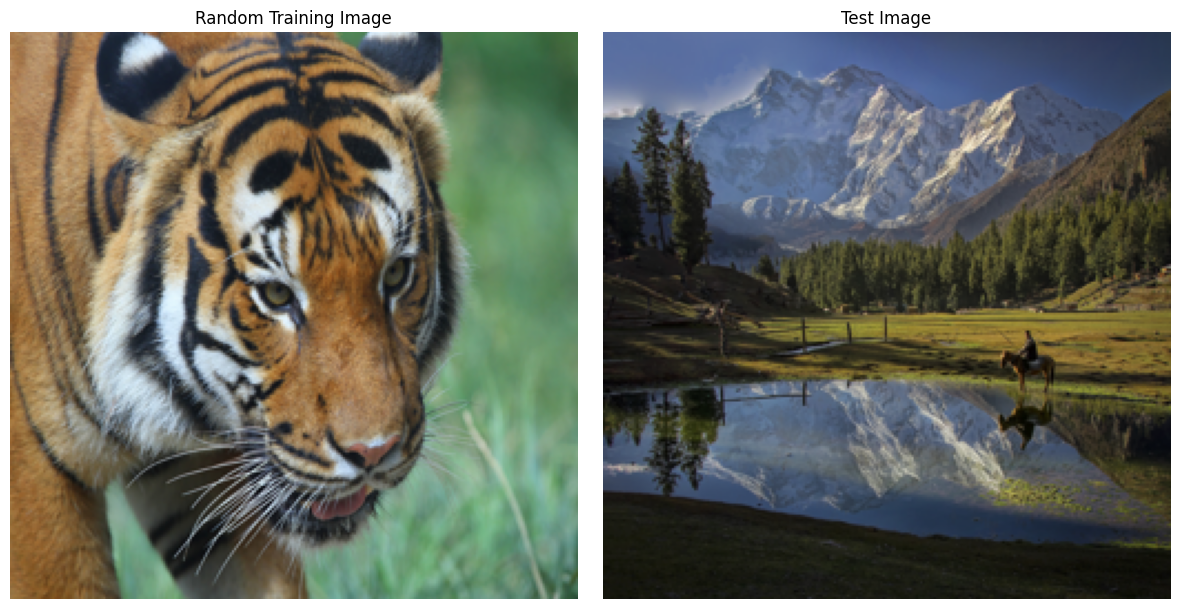

In [5]:
data_folder = 'data'
image_paths = [os.path.join(data_folder, fname) for fname in os.listdir(data_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Parameter: Number of images to use for training
num_train_images = 3

# Randomly select a single image for testing
test_image_path = random.choice(image_paths)

# Select training images (exclude the test image)
train_image_paths = [path for path in image_paths if path != test_image_path]
train_image_paths = random.sample(train_image_paths, num_train_images)

# Load datasets
train_datasets = [SingleImagePatchDataset(path) for path in train_image_paths]
test_dataset = SingleImagePatchDataset(test_image_path)

# Combine training datasets
combined_dataset = torch.utils.data.ConcatDataset(train_datasets)

# DataLoader
train_loader = DataLoader(combined_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionedSiren().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

random_train_image = random.choice(train_datasets).img_tensor.permute(1, 2, 0).cpu().numpy()
test_image = test_dataset.img_tensor.permute(1, 2, 0).cpu().numpy()

# Denormalize images
random_train_image = (random_train_image + 1) / 2
test_image = (test_image + 1) / 2

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(random_train_image.clip(0, 1))
plt.title("Random Training Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_image.clip(0, 1))
plt.title("Test Image")
plt.axis('off')

plt.tight_layout()
plt.show()


Training Progress:  50%|█████     | 1/2 [00:30<00:30, 30.19s/it]

Epoch 1, Loss: 0.0054
Epoch 2, Loss: 0.0047


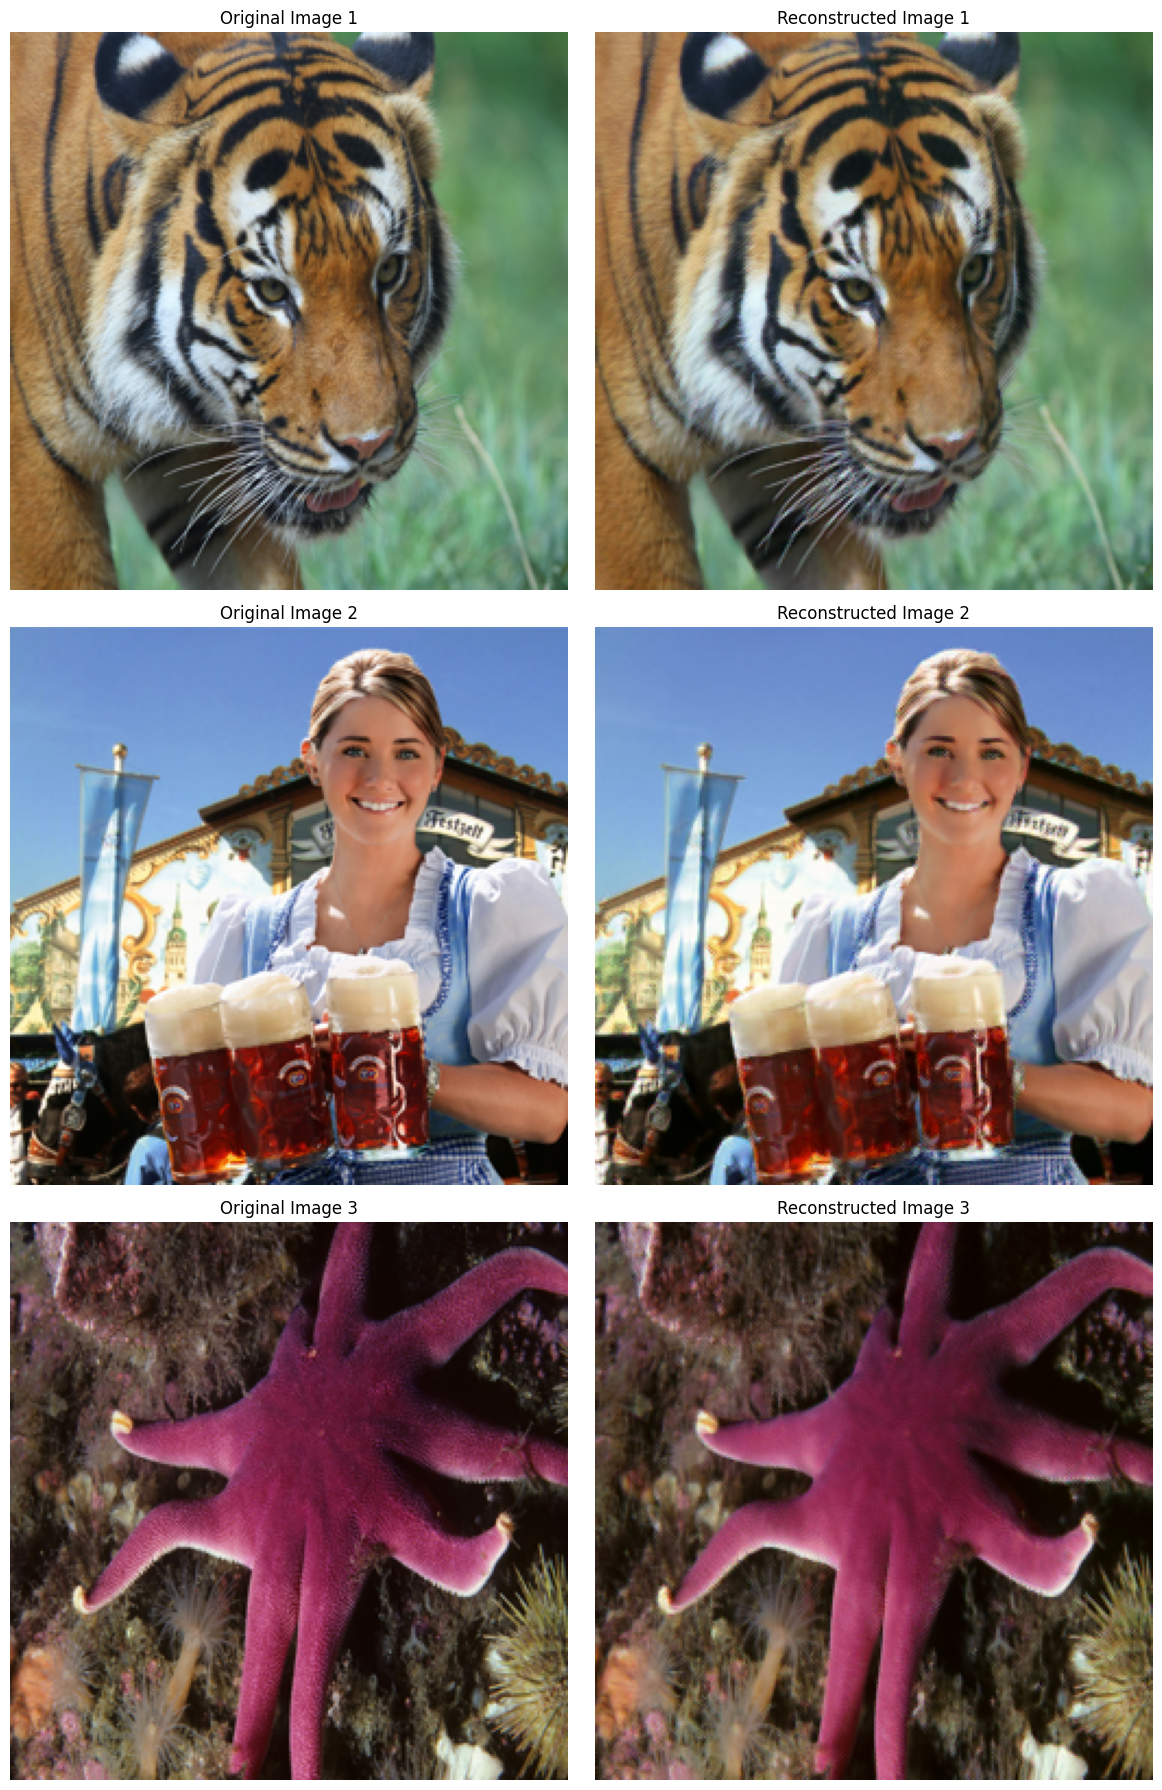

Training Progress: 100%|██████████| 2/2 [01:00<00:00, 30.08s/it]


<Figure size 640x480 with 0 Axes>

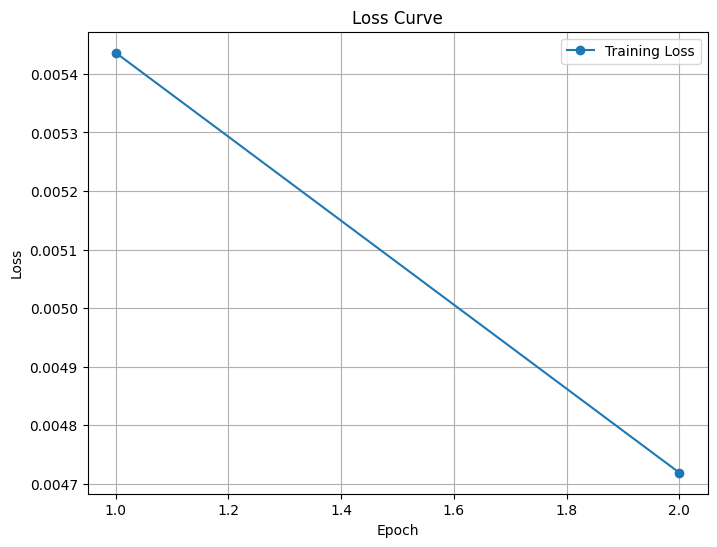

In [8]:
# Track losses
losses = []
epochs = 2

visualize_every = 2  # Show image every 2 epochs
pad = combined_dataset.datasets[0].pad_size  # Use the pad size from one of the datasets in combined_dataset

# Training loop
for epoch in tqdm(range(epochs), desc="Training Progress"):
    epoch_loss = 0  # Track loss for the current epoch

    for batch in train_loader:
        coords = batch['coord'].to(device)
        patches = batch['patch'].to(device)
        targets = batch['target'].to(device)

        # Forward pass
        preds = model(coords, patches)
        loss = F.mse_loss(preds, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

    # Visualization every `visualize_every` epochs
    if (epoch + 1) % visualize_every == 0:
        model.eval()
        with torch.no_grad():
            num_datasets = len(combined_dataset.datasets)
            plt.figure(figsize=(12, 6 * num_datasets))  # Adjust figure size for multiple rows

            for i, dataset in enumerate(combined_dataset.datasets):
                # Create full grid inference for each dataset in combined_dataset
                all_coords = dataset.coords.to(device)

                # Get all patches at once using unfold
                padded_img = F.pad(dataset.img_tensor.unsqueeze(0), (pad,) * 4, mode='reflect')[0]  # 1xCxHxW
                patches = padded_img.unfold(1, 3, 1).unfold(2, 3, 1)  # CxHxWx3x3
                patches = patches.permute(1, 2, 0, 3, 4)  # HxWxCx3x3
                patches = patches.reshape(-1, 3, 9)  # (H*W)x3x9
                # Remove center pixels (index 4 in each channel's 3x3 patch)
                patches = torch.cat([patches[:, :, :4], patches[:, :, 5:]], dim=2)  # (H*W)x3x8
                patches = patches.reshape(-1, 24)  # (H*W)x24

                # Predict full image
                preds = model(all_coords, patches.to(device))
                reconstructed = preds.cpu().numpy().reshape(dataset.img_tensor.shape[1],
                                                            dataset.img_tensor.shape[2], 3)

                # Denormalize
                reconstructed = (reconstructed + 1) / 2
                original = (dataset.img_tensor.permute(1, 2, 0).cpu().numpy() + 1) / 2

                # Plot original image
                plt.subplot(num_datasets, 2, 2 * i + 1)
                plt.imshow(original.clip(0, 1))
                plt.title(f"Original Image {i + 1}")
                plt.axis('off')

                # Plot reconstructed image
                plt.subplot(num_datasets, 2, 2 * i + 2)
                plt.imshow(reconstructed.clip(0, 1))
                plt.title(f"Reconstructed Image {i + 1}")
                plt.axis('off')

            plt.tight_layout()
            plt.pause(0.01)
            plt.draw()

        model.train()

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

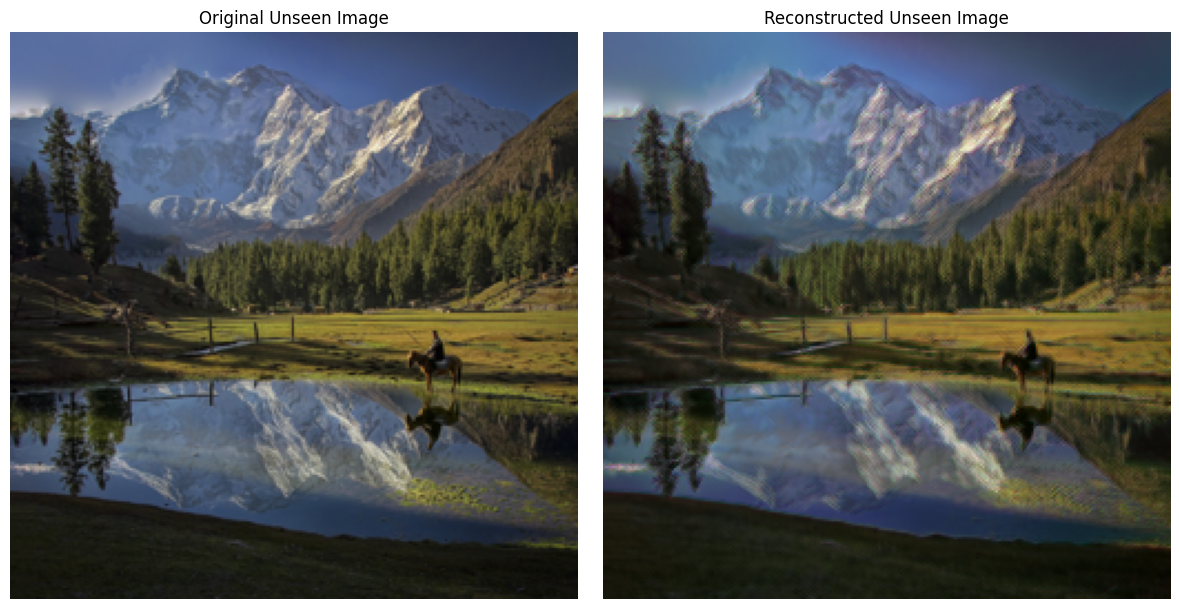

In [9]:
# Move the model to evaluation mode
model.eval()

# Get the original unseen image for comparison
original_unseen_img = (test_dataset.img_tensor.permute(1, 2, 0).cpu().numpy() + 1) / 2

# Create a grid of coordinates for the unseen image
all_coords = test_dataset.coords.to(device)

# Get all patches for the unseen image
pad = test_dataset.pad_size
padded_img = F.pad(test_dataset.img_tensor.unsqueeze(0), (pad,) * 4, mode='reflect')[0]  # 1xCxHxW
patches = padded_img.unfold(1, 3, 1).unfold(2, 3, 1)  # CxHxWx3x3
patches = patches.permute(1, 2, 0, 3, 4)  # HxWxCx3x3
patches = patches.reshape(-1, 3, 9)  # (H*W)x3x9
# Remove center pixels (index 4 in each channel's 3x3 patch)
patches = torch.cat([patches[:, :, :4], patches[:, :, 5:]], dim=2)  # (H*W)x3x8
patches = patches.reshape(-1, 24)  # (H*W)x24

# Predict the unseen image
with torch.no_grad():
    preds = model(all_coords, patches.to(device))
    reconstructed_unseen_img = preds.cpu().numpy().reshape(test_dataset.img_tensor.shape[1],
                                                           test_dataset.img_tensor.shape[2], 3)

# Denormalize the reconstructed image
reconstructed_unseen_img = (reconstructed_unseen_img + 1) / 2

# Visualize the original and reconstructed unseen image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_unseen_img.clip(0, 1))
plt.title("Original Unseen Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_unseen_img.clip(0, 1))
plt.title("Reconstructed Unseen Image")
plt.axis('off')

plt.tight_layout()
plt.show()